In [23]:
import numpy as np
import logging 
import time 
from datetime import datetime
import json
from pathlib import Path

from src import ParameterSet, Plot
from src import ModelBase as Model
from src.integral import itoint

from src.model_base import ModelBase
import matplotlib.pyplot as plt

# np.seterr(all='raise')
np.set_printoptions(precision=4, suppress=True, linewidth=200)
logging.basicConfig(level=logging.WARN)

In [24]:
def run(t_end, changes = {}, *, dt=0.001, path:Path=None):
    print(f'estimated time: {1.1 * t_end/dt / 1000} seconds')
    t_start = time.time()
    t = np.linspace(0, t_end, int(t_end / dt) + 1)
    y0 = Model()
    y0.initialize()
    params = ParameterSet("structure.json")
    params.batch_update(changes)
    params.J.print_matrix()
    params.J_ampa.print_matrix()
    print(json.dumps(params.__flat_json__(ignore_zeros=True), indent=2))
    if path is not None:
        params.save(path / 'params.json')
        params.saveDelta(path / 'params_delta.json',base_file='structure.json')
        params.saveDeltaHtml(path / 'params_delta.html',base_file='structure.json')

    def calc_g_static():
      sigma = y0.serialize_g(params)
      g_vector = sigma * params.constants.tau_y
      g_matrix = np.diag(g_vector)
      g_matrix = g_matrix[:,~np.all(g_matrix == 0, axis=0)]
      g_matrix = g_matrix * 1.0
      return g_matrix
    
    g_matrix = calc_g_static()

    def model_f(y, t):
        Y = Model().deserialize(y)
        delta = Y.calcDelta(t, params)
        dy = delta.serialize()
        return dy

    def model_g(y, t):
        # Y = MyState().deserialize(y)
        # sigma = Y.serialize_g(params)
        # tau_y = params.constants.tau_y
        # g = sigma * tau_y
        # return np.diag(g_vector)
        return g_matrix.copy()

    gen = np.random.Generator(np.random.PCG64(123))
    # res = sdeint.itoint(model_f, model_g, y0.serialize(), t, gen)
    res = itoint(model_f, model_g, y0.serialize(), t, gen)
    def toState(y): return Model().deserialize(y)
    t_end = time.time()
    print(f'elapsed time: {t_end - t_start} seconds')
    return t, list(map(toState, res))

In [25]:
def get_trace( address, t: np.array, res: list[ModelBase], t_start, t_end):
    _t = np.where((t >= t_start) & (t <= t_end))
    idx_start = _t[0][0]
    idx_end = _t[0][-1]
    _res = res[idx_start:idx_end+1]
    tmp = [x for x in _res]
    for key in address.split('.'):
        print(key)
        tmp = [getattr(x, key) for x in tmp]
    return np.array(tmp)

In [31]:
new_params = {"sst1.I_back.dc": 0.25,"sst2.I_back.dc": 0.25,
                "vip1.I_back.type": "sin", "vip1.I_back.amplitude": 0.1, 
                "vip1.I_back.frequency": 4, "vip2.I_back.type": "sin", 
                "vip2.I_back.amplitude": 0.1, "vip2.I_back.frequency": 4,
                "exc1.I_back.amplitude": 0., "exc1.I_back.frequency": 0,
                "exc2.I_back.amplitude": 0.,"exc2.I_back.frequency": 0}

In [34]:
experiments = [{"constants.ratio":0.0},{"constants.ratio":0.25}]
if __name__ == '__main__':
    exp = 'opto'
    signals=[]
    for e in range(len(experiments)):
        experiments[e].update(new_params) 
        dt = datetime.now()
        folder = Path(f'img/{exp}/{dt.strftime("%Y-%m-%d")}/{dt.strftime("%H%M%S")}')
        folder.mkdir(parents=True)
        t, res = run(10, changes = experiments[e] , dt=0.001, path=folder)
        trace = get_trace("exc1.r",t,res,t_start=0,t_end =10)
        signals.append(trace)
        # exc1_r = np.array([x.exc1.r for x in res])
        # exc2_r = np.array([x.exc2.r for x in res])
        # pv_r = np.array([x.pv.r for x in res])
        plots = [
            Plot(['exc1.r'], t_start=0, t_end=10, title='Exc 1 Firing Rate', file=folder / 'r1.svg'),
            Plot(['exc2.r'], t_start=0, t_end=10, title='Exc 2 Firing Rate', file=folder / 'r2.svg'),
            Plot(['pv.r'],   t_start=0, t_end=10, title='PV Firing Rate',    file=folder / 'pv.svg'),
            Plot(['sst1.r'], t_start=0, t_end=10, title='SST 1 Firing Rate', file=folder / 's1.svg'),
            Plot(['sst2.r'], t_start=0, t_end=10, title='SST 2 Firing Rate', file=folder / 's2.svg'),
            Plot(['vip1.r'], t_start=0, t_end=10, title='VIP 1 Firing Rate', file=folder / 'v1.svg'),
            Plot(['vip2.r'], t_start=0, t_end=10, title='VIP 2 Firing Rate', file=folder / 'v2.svg'),
            # Plot(['exc1.r'], t_start=2, t_end=3, title='Exc 1 Firing Rate', file=f'{folder}/r1-before.png'),
            # Plot(['exc1.r'], t_start=5, t_end=6, title='Exc 1 Firing Rate', file=f'{folder}/r1-during.png'),
            # Plot(['exc1.r'], t_start=7, t_end=8, title='Exc 1 Firing Rate', file=f'{folder}/r1-after.png'),
            # Plot(['exc1.r','exc2.r','pv.r'], t_start=3, t_end=7, title='Exc 1, 2, PV Firing Rate', file=f'{folder}/r1-r2.png'),
        ]
        for p in plots:
            p(t,res)
        plots_ref = [p.file.name for p in plots]
        plots_ref = [f'<div class="res-img"><img src="{p}"/></div>' for p in plots_ref]
        plots_ref = '\n'.join(plots_ref)

        html = folder / 'results.html'
        html.write_text(f'''<html>
    <head>
        <title> Summary </title>
        <style>
        .images {{display: flex; flex-wrap: wrap;}}
        .res-img {{}}
        </style>
    </head>
    <body>
    <section id="inputs">
        <iframe src="params_delta.html" onload='javascript:(function(o){{o.style.height=o.contentWindow.document.body.scrollHeight+"px";}}(this));' 
        style="height:200px;width:100%;border:none;overflow:hidden;"></iframe>
    </section>
    <section id="results">
        <div class="images">{plots_ref}</div>
    </section>
    </body>
    </html>''')

estimated time: 11.0 seconds
                exc1      exc2        pv      sst1      sst2      vip1      vip2
      exc1     0.481     0.011    -0.360    -0.450                              
      exc2     0.011     0.481    -0.360              -0.450                    
        pv     0.301     0.301    -0.120                                        
      sst1     0.350                                            -0.350          
      sst2               0.350                                            -0.350
      vip1     0.450                        -0.350                              
      vip2               0.450                        -0.350                    
                exc1      exc2        pv      sst1      sst2      vip1      vip2
      exc1     3.040     1.400                                                  
      exc2     1.400     3.040                                                  
        pv     2.560     2.560                                                  

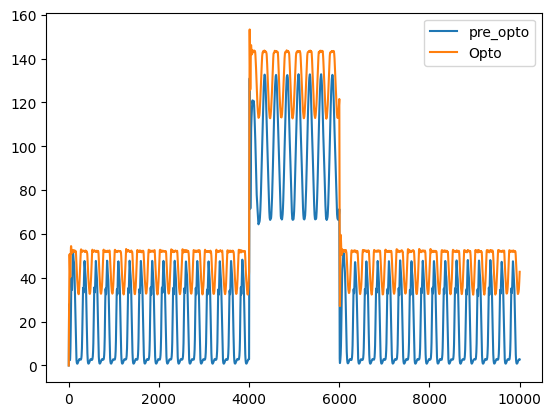

In [35]:
plt.plot(signals[0],label="pre_opto")
plt.plot(signals[1],label="Opto")
plt.legend()

In [36]:
from pactools import Comodulogram, REFERENCES
from pactools import simulate_pac

ozkurt... 
canolty... 
tort... 
penny... 
vanwijk... 
duprelatour... 
colgin... 


c:\Users\palavia\neural-simulation\venv\lib\site-packages\pactools\comodulogram.py:928: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  func = interp2d(x1, y1, z1.T, kind='linear', bounds_error=False)
c:\Users\palavia\neural-simulation\venv\lib\site-packages\pactools\comodulogram.py:929: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline`

sigl... 
bispectrum... 


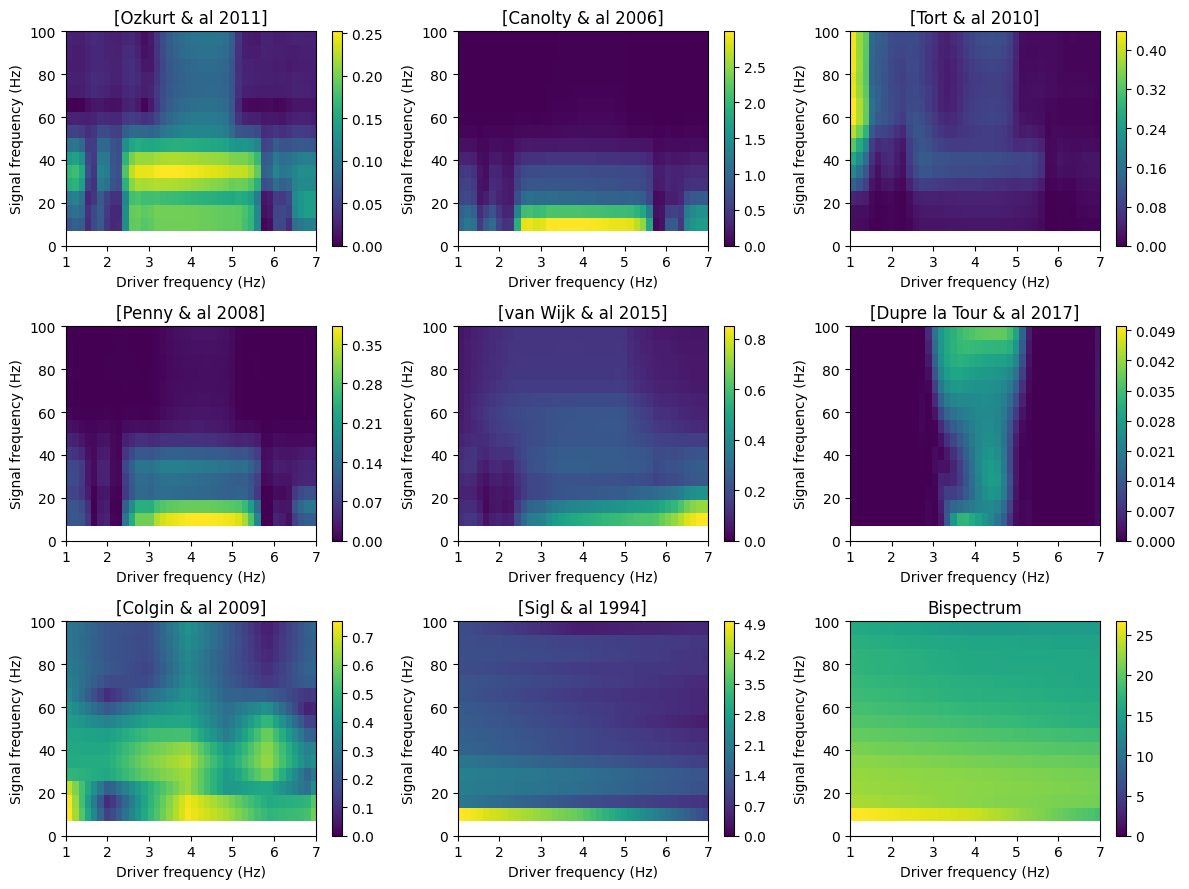

ozkurt... 
canolty... 
tort... 
penny... 
vanwijk... 
duprelatour... 
colgin... 


c:\Users\palavia\neural-simulation\venv\lib\site-packages\pactools\comodulogram.py:928: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  func = interp2d(x1, y1, z1.T, kind='linear', bounds_error=False)
c:\Users\palavia\neural-simulation\venv\lib\site-packages\pactools\comodulogram.py:929: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline`

sigl... 
bispectrum... 


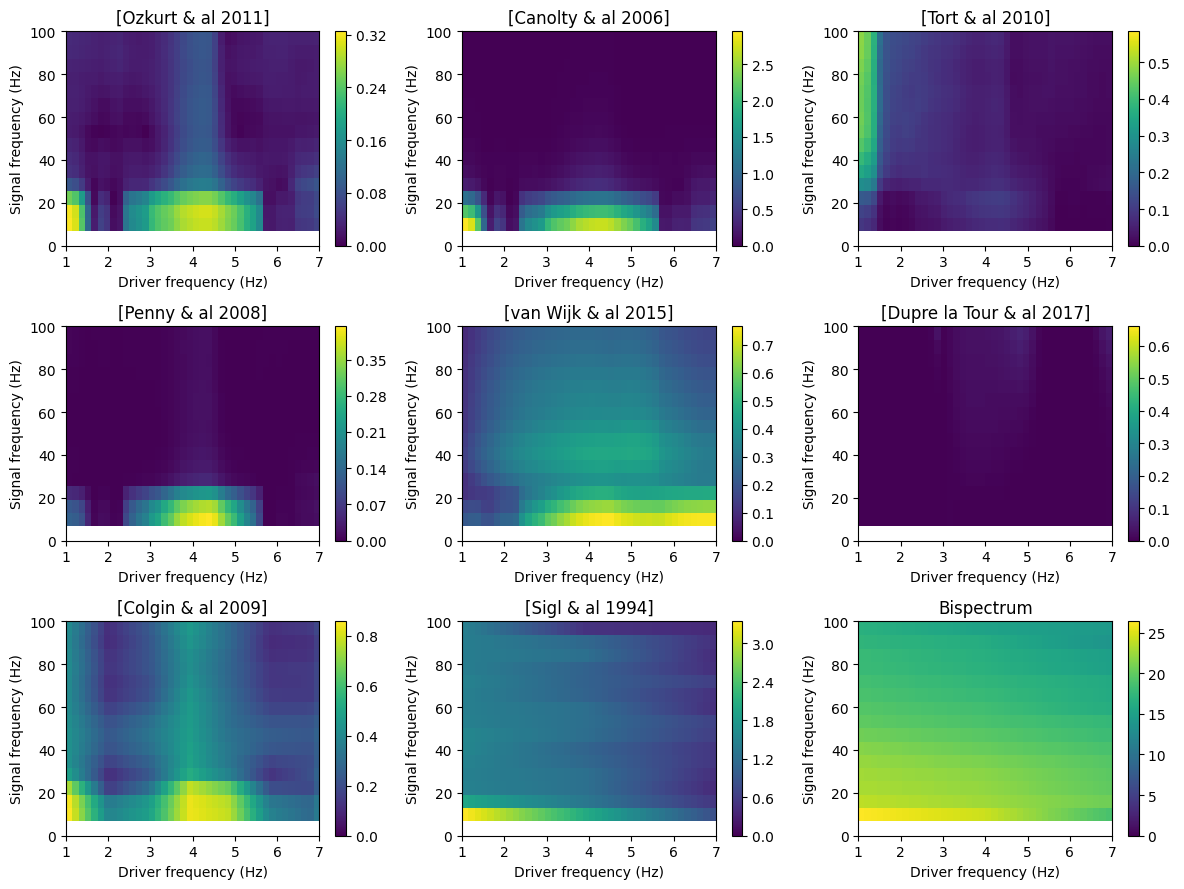

In [37]:

#params
fs=1000
low_fq_range = np.linspace(1, 7, 40)
methods = [
    'ozkurt', 'canolty', 'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin',
    'sigl', 'bispectrum'
]
low_fq_width = 1.0  # Hz

n_lines = 3
n_columns = int(np.ceil(len(methods) / float(n_lines)))




# Compute the comodulograms and plot them
for s in signals:
    fig, axs = plt.subplots(
    n_lines, n_columns, figsize=(4 * n_columns, 3 * n_lines))
    axs = axs.ravel()
    for ax, method in zip(axs, methods):
        print('%s... ' % (method, ))
        estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                                low_fq_width=low_fq_width, method=method,
                                progress_bar=False)
        estimator.fit(s)
        estimator.plot(titles=[REFERENCES[method]], axs=[ax])
        ax.set_ylim([0, 100])

    plt.show()

ozkurt... 
canolty... 
tort... 
penny... 
vanwijk... 
duprelatour... 
colgin... 


c:\Users\palavia\neural-simulation\venv\lib\site-packages\pactools\comodulogram.py:928: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  func = interp2d(x1, y1, z1.T, kind='linear', bounds_error=False)
c:\Users\palavia\neural-simulation\venv\lib\site-packages\pactools\comodulogram.py:929: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline`

sigl... 
bispectrum... 


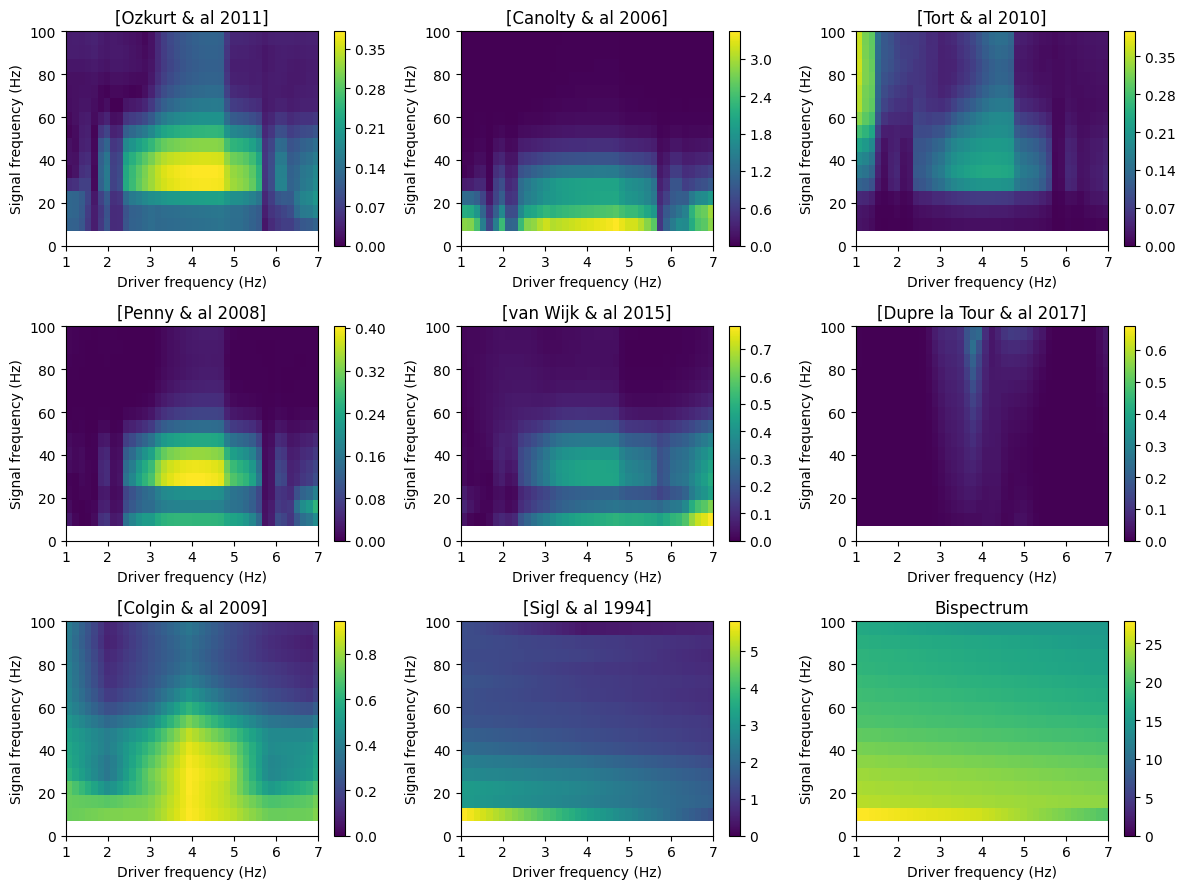

In [41]:

#params
fs=1000
low_fq_range = np.linspace(1, 7, 40)
methods = [
    'ozkurt', 'canolty', 'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin',
    'sigl', 'bispectrum'
]
low_fq_width = 1.0  # Hz

n_lines = 3
n_columns = int(np.ceil(len(methods) / float(n_lines)))
fig, axs = plt.subplots(
    n_lines, n_columns, figsize=(4 * n_columns, 3 * n_lines))
axs = axs.ravel()



# Compute the comodulograms and plot them
for ax, method in zip(axs, methods):
    print('%s... ' % (method, ))
    estimator = Comodulogram(fs=fs, low_fq_range=low_fq_range,
                             low_fq_width=low_fq_width, method=method,
                             progress_bar=False)
    estimator.fit(signals[1])
    estimator.plot(titles=[REFERENCES[method]], axs=[ax])
    ax.set_ylim([0, 100])

plt.show()